In [73]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.externals import joblib


In [74]:
#MSSubClass is set of discrete ints, so this makes it easier to use it as a categorical feature
train_clean = pd.read_csv('train_clean.csv', dtype={'MSSubClass': str})  
train = pd.read_csv('train.csv', dtype={'MSSubClass': str})

In [75]:
kf = KFold( 4, shuffle=True)

In [123]:
val_idx_list = []
val_preds = []
train_preds = []
val_errors = []
train_rmse = []
val_rmse = []

for tr_idx, val_idx in kf.split(train):
    X_tr, y_tr = X_train.iloc[tr_idx, :], y_train.iloc[tr_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    val_idx_list.append(val_idx)
    ls = Lasso(alpha=0.001) #the hyperparameter we found to be best
    ls.fit(X_tr, y_tr)
    preds = ls.predict(X_val)
    val_preds.append(preds)
    val_errors.append(np.abs(y_val.values - preds))
    tr_preds = ls.predict(X_tr)
    train_preds.append(tr_preds)
    train_rmse.append(np.mean(np.sqrt((y_tr.values - tr_preds)**2)))
    val_rmse.append(np.mean(np.sqrt((y_val.values - preds)**2)))

print("mean val error: {}".format(np.mean(val_rmse)))
print("mean train error: {}".format(np.mean(train_rmse)))
    

mean val error: 0.08205030063017466
mean train error: 0.07413671746790224


In [124]:
val_idx = np.concatenate([l for l in val_idx_list])
val_preds = np.concatenate([p for p in val_preds])
val_errors = np.concatenate([e for e in val_errors])
merge_df = pd.DataFrame(np.hstack([val_preds[:, np.newaxis], val_errors[:, np.newaxis]]), columns=['log_pred', 'log_error'], index=val_idx)
err_df = train.merge(merge_df, left_index=True, right_index=True)

In [125]:
err_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_pred,log_error
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,12.072969,0.223564
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,307000,12.536456,0.098151
15,16,45,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,GdPrv,NaN,0,7,2007,WD,Normal,132000,11.797304,0.006739
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,NaN,Shed,700,3,2010,WD,Normal,149000,11.946573,0.034865
20,21,60,RL,101.0,14215,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,11,2006,New,Partial,325300,12.664523,0.027983


In [127]:
err_df['pred'] = np.expm1(err_df.log_pred)
err_df['abs_error'] = np.abs(err_df.SalePrice - err_df.pred)
err_df['error'] = -(err_df.SalePrice - err_df.pred)

In [128]:
err_df.error.describe()

count      1460.000000
mean      -1935.959548
std       32403.713485
min     -296013.784554
25%      -10600.612040
50%        -717.475005
75%        8371.034619
max      724151.691612
Name: error, dtype: float64

Let's plot the errors versus saleprice and our predictions to get a better sense of where we went wrong.

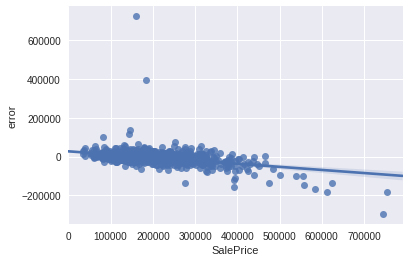

In [129]:
sns.regplot(x='SalePrice', y='error', data=err_df)

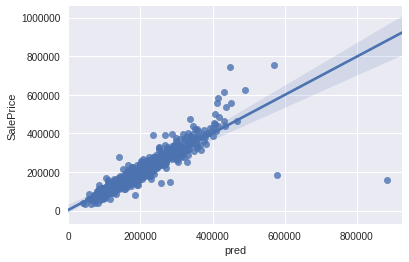

In [130]:
sns.regplot(y='SalePrice', x='pred', data=err_df)

It looks like we have four houses where we were way off. Let's take a look at them.

In [139]:
most_wrong = err_df.sort_values('abs_error', ascending=False)

In [138]:
most_wrong.SaleCondition.value_counts()

Normal     39
Partial    24
Abnorml     8
Alloca      2
Family      2
Name: SaleCondition, dtype: int64

In [84]:
most_wrong.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_pred,log_error,pred,abs_error,error
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,1,2008,New,Partial,160000,13.712189,1.729253,901835.679236,741835.679236,741835.679236
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,7,2007,WD,Abnorml,745000,12.404540,1.116601,243905.470122,501094.529878,-501094.529878
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,10,2007,New,Partial,184750,13.297377,1.170613,595630.161568,410880.161568,410880.161568
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,1,2007,WD,Normal,755000,13.220043,0.314431,551303.982539,203696.017461,-203696.017461


From a previous notebook, we learned that GrLivingArea, Neighborhood and OverallQual were the most important features. So let's hone in on those. 

In [85]:
most_wrong.GrLivArea

1298    5642
1182    4476
523     4676
691     4316
Name: GrLivArea, dtype: int64

In [86]:
train.GrLivArea.mean()

1515.463698630137

In [110]:
most_wrong.Neighborhood

1298    Edwards
1182    NoRidge
523     Edwards
691     NoRidge
Name: Neighborhood, dtype: object

In [88]:
most_wrong.OverallQual

1298    10
1182    10
523     10
691     10
Name: OverallQual, dtype: int64

In [91]:
train.OverallQual.mean()

6.0993150684931505

We can see that our potential outliers are large, high-quality houses. What's interesting is that we predicted too low a price for two of them, and two high a price for the other two. Two of the houses are partial sales and one was abnormal. Maybe that has something to do with it?

Neighborhood could also be the culprit. When we fit our original model, we found the Edwards neighborhood to be one of the strongest negative predictors of price. The two houses where we predicted too high a price were in Edwards. Maybe that's what dragged their price down?

Let's remove the outliers, fit a new model, and see what happens.

In [97]:
no_outliers = train_clean.drop(train_clean.index[most_wrong.index.values])

In [99]:
X = no_outliers.drop('SalePrice', axis=1)
y = no_outliers['SalePrice']

In [100]:
ls = Lasso(alpha=0.001)

In [102]:
X_test = pd.read_csv('test_clean.csv')

In [105]:
preds = ls.predict(X_test)

In [106]:
preds = np.expm1(preds)

solution = pd.DataFrame({"id":X_test.Id, "SalePrice":preds}, columns=['id', 'SalePrice'])

solution.to_csv("lasso_no_outliers.csv", index = False)

That submission did score better that our previous submission. But I later discovered that removing only two of those four houses (the ones for which we predicted too high a price) worked even better. I think this is because many of our larger errors tended to be underpredicting price, and the outliers we removed were causing some of this.

## Do it again

In [111]:
val_idx_list = []
val_preds = []
train_preds = []
val_errors = []
train_rmse = []
val_rmse = []

for tr_idx, val_idx in kf.split(X):
    X_tr, y_tr = X.iloc[tr_idx, :], y.iloc[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    val_idx_list.append(val_idx)
    ls = Lasso(alpha=0.001) #the hyperparameter we found to be best
    ls.fit(X_tr, y_tr)
    preds = ls.predict(X_val)
    val_preds.append(preds)
    val_errors.append(np.abs(y_val.values - preds))
    tr_preds = ls.predict(X_tr)
    train_preds.append(tr_preds)
    train_rmse.append(np.mean(np.sqrt((y_tr.values - tr_preds)**2)))
    val_rmse.append(np.mean(np.sqrt((y_val.values - preds)**2)))

print("mean val error: {}".format(np.mean(val_rmse)))
print("mean train error: {}".format(np.mean(train_rmse)))
    

mean val error: 0.07851884115153562
mean train error: 0.07212970079876267


In [112]:
val_idx = np.concatenate([l for l in val_idx_list])
val_preds = np.concatenate([p for p in val_preds])
val_errors = np.concatenate([e for e in val_errors])
merge_df = pd.DataFrame(np.hstack([val_preds[:, np.newaxis], val_errors[:, np.newaxis]]), columns=['log_pred', 'log_error'], index=val_idx)
err_df = train.merge(merge_df, left_index=True, right_index=True)

In [113]:
err_df['pred'] = np.expm1(err_df.log_pred)
err_df['abs_error'] = np.abs(err_df.SalePrice - err_df.pred)
err_df['error'] = -(err_df.SalePrice - err_df.pred)

In [ ]:
#remove outliers
#train = train[(train.Id != 1299) & (train.Id != 524)]


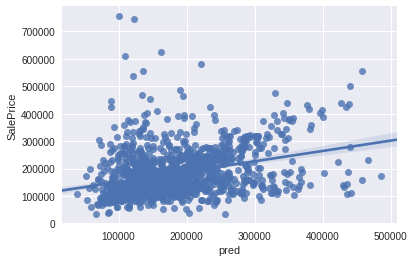

In [114]:
sns.regplot(y='SalePrice', x='pred', data=err_df)

In [115]:
most_wrong = err_df.sort_values('abs_error', ascending=False)[:10

In [117]:
most_wrong.GrLivArea

691     4316
1182    4476
898     2364
1169    3627
1046    2868
769     3279
803     2822
527     2713
1142    2828
1373    2633
Name: GrLivArea, dtype: int64

In [118]:
most_wrong.OverallQual

691     10
1182    10
898      9
1169    10
1046     9
769      8
803      9
527      9
1142     8
1373    10
Name: OverallQual, dtype: int64

In [119]:
most_wrong.Neighborhood

691     NoRidge
1182    NoRidge
898     NridgHt
1169    NoRidge
1046    StoneBr
769     StoneBr
803     NridgHt
527     NridgHt
1142    CollgCr
1373    NoRidge
Name: Neighborhood, dtype: object

In [120]:
most_wrong.SaleCondition

691      Normal
1182    Abnorml
898     Partial
1169     Normal
1046    Partial
769      Normal
803     Partial
527     Partial
1142    Partial
1373     Normal
Name: SaleCondition, dtype: object

In [122]:
train.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64